<div>
<img src="header5.png" width="1000" float='left', style="display:block">
</div>
<a id='tartalomjegyzek'></a>

# Üzleti Intelligencia - Adatelemzési Feladat
**Radó László, MS1PB5. 2020 Április**
<br>
<hr>
<hr>

## 2) Feltáró adatelemzés


### Tartalomjegyzék:
<blockquote>
<ul>
<li><a href="#eljarasok">Az elemzéshez szükséges saját eljárások</a></li>
    
**Vizuális elemzések:**
<li><a href="#korrel">Korrelációs mátrix</a></li>
<li><a href="#gender">Nemek szerinti megoszlások vizsgálata</a></li>
<li><a href="#age">Életkor hatása a megjelenésre</a></li>
<li><a href="#betegseg">Krónikus betegségek hatása a megjelenésre</a></li>
<li><a href="#korabbi">Korábbi vizsgálati alkalmak, és korábbi meg nem jelenések hatása</a></li>
<li><a href="#idopont">Vizsgálat időpontjának hatása a megjelenésre</a></li>
<li><a href="#varosresz">Varosrész hatásának vizsgálata a megjelenésre</a></li>
<li><a href="#egyeb">Egyéb Változók hatásának vizsgálata</a></li>
<br>
    
<li><a href="#konkluzio">Konklúzió</a></li>
</ul>
</blockquote>

In [59]:
# Adatok és szükséges könyvtárak beolvasása
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib.patches as mpatches
import matplotlib.ticker as mtick
%matplotlib inline

# Vizualizációhoz használt szinek és egyedi paletta elkészítése
base0 = '#7D8597'
base1 = '#5C677D'
accent0 = '#F72585'
accent1 = '#aacc00'

# Egyedi colormap létrehozása
from matplotlib.cm import get_cmap
import matplotlib.colors
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", [base0,'white'])
cmap2 = matplotlib.colors.LinearSegmentedColormap.from_list("", [accent0,'white',base0])


# Adatook beolvasása
no_show =  pd.read_csv('KaggleV2-May-2016_clean.csv', 
                       index_col='AppointmentID',
                       infer_datetime_format=True, 
                       parse_dates=['ScheduledDay', 'AppointmentDay'])
dummies = pd.get_dummies(no_show['betegsegek_szama'].astype(str))
no_show = pd.concat([no_show, dummies], axis=1)
no_show.head()

,Unnamed: 0,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighborhood,Osztondij,Magas_vernyomas,Cukorbeteseg,...,dummy_17.1,dummy_18.1,dummy_19.1,dummy_20.1,dummy_21.1,0,1,2,3,4
AppointmentID,,,,,,,,,,,,,,,,,,,,,
5642903,0,29872499824296,Nő,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,...,0,1,0,0,0,0,1,0,0,0
5642503,1,558997776694438,Férfi,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5642549,2,4262962299951,Nő,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5642828,3,867951213174,Nő,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,...,1,0,0,0,0,1,0,0,0,0
5642494,4,8841186448183,Nő,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,1,1,...,0,0,0,0,0,0,0,1,0,0


<a id='eljarasok'></a>
## Saját eljárások
<a href="#tartalomjegyzek">Vissza a tartalomjegyzékhez</a>

In [2]:
def custom_bar(ax, label, height, width, title, bar_color='', edgecolor='',
               text_color='white', text_position=-0.015, show_text='pct', bottom='', name=''):
    if bar_color == '':
        bar_color = base1
        
    if edgecolor =='':
        edgecolor = accent0
    
    # Oszlopdiagram létrehozása
    if bottom != '':
        ax.bar(labels, height, width, color=bar_color, edgecolor=edgecolor, bottom=bottom, label=name)
    else:
        ax.bar(labels, height, width, color=bar_color, edgecolor=edgecolor, label=name)
    
    # Oszlopdiagram formázása
    ax.set_title(title)
    ax.spines['left'].set_visible(True)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.axes.yaxis.set_visible(True)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    
    # Százalékos értékek megjelenítése az oszlopdiagramon
    for kat, ertek in zip(labels, height):

        if show_text == 'pct':
            text = str(np.round((ertek),1)) + "%"
        elif show_text == 'abs':
            text = str(ertek)
        else:
            text = ''
        ax.text(kat, ertek + text_position, text, ha='center', color=text_color)
        

def prop_show_labels(df, labels):
    from collections import defaultdict
    from functools import partial
    
    results = defaultdict(partial(np.ndarray, 0))

    for col in labels:
        
        count_total = df[df[col]==1].shape[0]
        count_show = df[(df[col]==1) & (df['No-show']=='Megjelent')].shape[0]
        ratio = count_show / count_total
        
        results['heights'] = np.append(results['heights'], ratio)
        results['labels'] = np.append(results['labels'], col)

    return results


def prob_show_crosstab(df, group_by):
    df = pd.crosstab(index = df[group_by], columns = df['No-show']).reset_index()
    df['prob_megjelenes'] = df['Megjelent'] / (df['Nem jelent meg'] + df['Megjelent'])
    return df[[group_by, 'prob_megjelenes']]

<a id='korrel'></a>
## Korrelációs Mátrix
<a href="#tartalomjegyzek">Vissza a tartalomjegyzékhez</a>

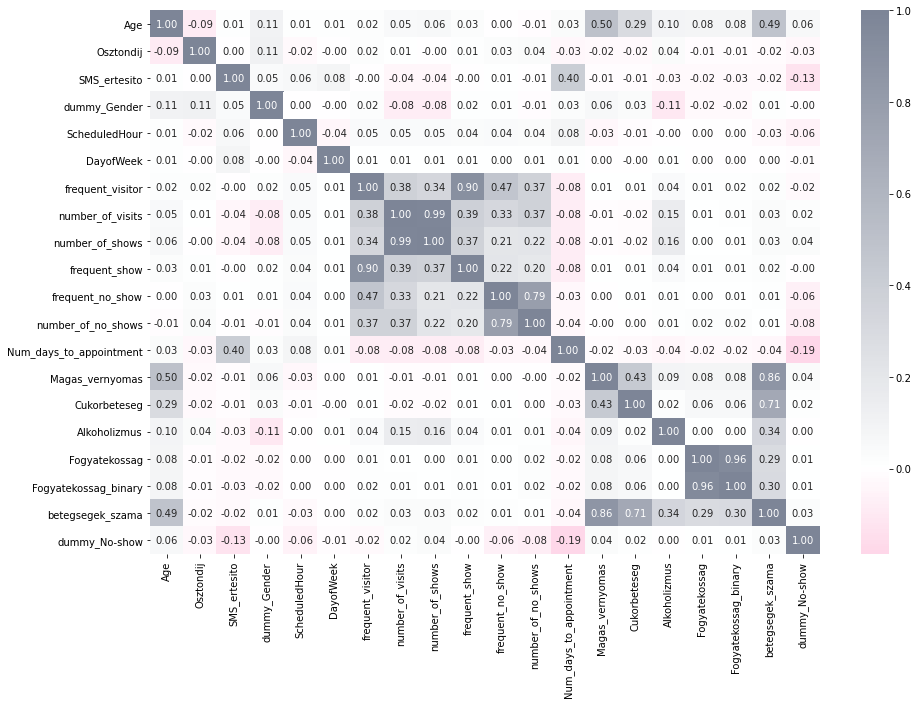

In [48]:
variables_for_correlation_1 = [
 'Age',
#  'Age_capped_80',
 
 'Osztondij',
 'SMS_ertesito',
      
 'dummy_Gender',

 'ScheduledHour',
 'DayofWeek',
  
 'frequent_visitor',
 'number_of_visits',
#  'number_of_visits_capped',
#  'number_of_visits_capped_mult',
#  'number_of_visits_sq_mult',
    
 'number_of_shows',
#  'number_of_shows_capped',
 'frequent_show',
 
 'frequent_no_show',
 'number_of_no_shows',
#  'number_of_no_shows_capped',
  
 'Num_days_to_appointment',
#  'Num_days_to_appointment_capped',
      
 'Magas_vernyomas',
 'Cukorbeteseg',
 'Alkoholizmus',
 'Fogyatekossag',
 'Fogyatekossag_binary',
 'betegsegek_szama',
#  'betegsegek_szama_capped',
#  '0',
#  '1',
#  '2',
#  '3',
#  '4',
 'dummy_No-show',
 ]

fig = plt.figure(figsize=(15, 10))
corr = no_show[variables_for_correlation_1]
sb.heatmap(corr.corr(), annot = True, fmt = '.2f', cmap = cmap2, center = 0);

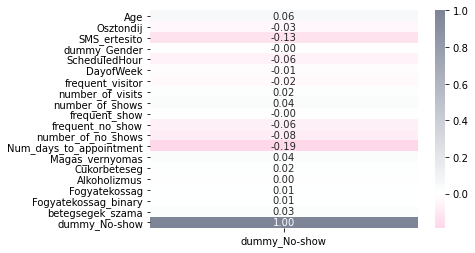

In [54]:
sb.heatmap(corr.corr()[['dummy_No-show']], annot = True, fmt = '.2f', cmap = cmap2, center = 0);

#### Megfigyelések:
* A fenti korrelációs mátrixban viszont csak a **totális korrelációs együtthatók** (páronkénti) láthatók, a parciális hatások ettől eltérhetnek, és a modellünk szempontjából elsősorban ezek lesznek a fontosak.
* Ettől függetlenül az már látható, hogy egyik magyarázó változó sem mutat gyengénél erősebb kapcsolatot a célváltozónkkal (dummy_No-show, legalul), így **a modellünk magyarázó ereje várhatóan nem lesz magas.**

#### További feladatok:
* Az egyes városrészek hatása nincs benne a korrelációs mátrixban, így az további vizsgálatot igényel.
* Végezzünk további elemzéseket a célváltozó, és a magyarázó változók kapcsolatára vonatkozóan.
 * Különös figyelemmel az összefüggés alakjára, outlierekre, homoszkedaszticitásra, és hogy ezek bármilyen további transzformációval történő orvoslása javíthatja e a modell várt magyarázóerejét

<a id='gender'></a>
## Nemek szerinti megoszlás vizsgálata
<a href="#tartalomjegyzek">Vissza a tartalomjegyzékhez</a>

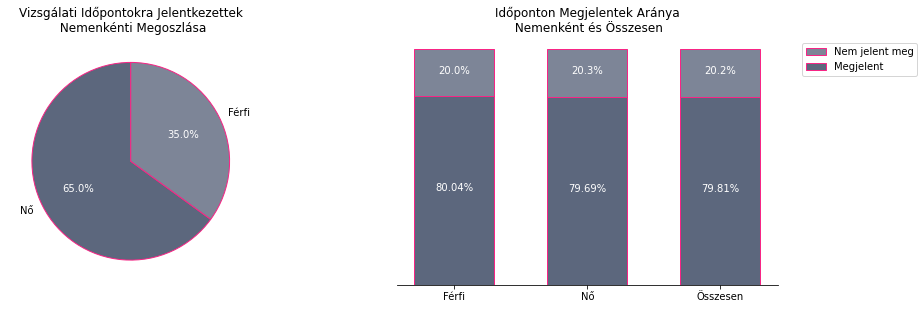

In [4]:
fig = plt.figure(figsize=(15, 10))
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)

# A nem (Gender) változó értékeinek megoszlása
gender_dist = no_show.Gender.value_counts()

_, labels, _ = ax1.pie(gender_dist, 
                       labels=gender_dist.index, 
                       autopct='%.1f%%', 
                       startangle=90, 
                       colors=[base1, base0],
                       textprops={'color':"w"},
                       wedgeprops={"edgecolor":accent0})

colorlist = ['black', 'black', 'w', 'w']
for text, color in zip(labels, colorlist):
    text.set_color(color)

ax1.set_title('Vizsgálati Időpontokra Jelentkezettek\n Nemenkénti Megoszlása')


# Megjelentek aránya nemenként és összesen
# Adatelőkészítés
count_ferfi = no_show[no_show['Gender']=='Férfi'].shape[0]
count_ferfi_megjelent = no_show[(no_show['Gender']=='Férfi') & (no_show['No-show']=='Megjelent')].shape[0]
arany_ferfi_megjelent = count_ferfi_megjelent / count_ferfi

count_no = no_show[no_show['Gender']=='Nő'].shape[0]
count_no_megjelent = no_show[(no_show['Gender']=='Nő') & (no_show['No-show']=='Megjelent')].shape[0]
arany_no_megjelent = count_no_megjelent / count_no

count_total = no_show.shape[0]
count_total_megjelent = no_show[(no_show['No-show']=='Megjelent')].shape[0]
arany_total_megjelent = count_total_megjelent / count_total

# Bar-chart paraméterváltozóinak előkészítése
width = 0.6
labels = ['Férfi', 'Nő', 'Összesen']
heights = np.array([arany_ferfi_megjelent, arany_no_megjelent, arany_total_megjelent])


# Bar-chart
ax2.bar(labels, 1-heights, width, label='Nem jelent meg', bottom=heights, color=base0, edgecolor=accent0)
ax2.bar(labels, heights, width, label='Megjelent', color=base1, edgecolor=accent0)


# Bar-chart formatting
ax2.set_title('Időponton Megjelentek Aránya\n Nemenként és Összesen')
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.axes.yaxis.set_visible(False)


# Bar-chart étékek megjelenítése
for nem, height in zip(labels, heights):
    nem_jelent_meg_text = str(np.round((1 - height) * 100,1)) + "%"
    megjelent_text = str(np.round(height* 100,2)) + "%"

    ax2.text(nem, height + (1-height)/2, str(nem_jelent_meg_text), ha='center', color="w")
    ax2.text(nem, height / 2, str(megjelent_text), ha='center', color="white")


# Bar-chart legend
ax2.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left');

##### Nemek és megjelenés megoszlásai:
* A férfiak aránya az adatállományban 35%, míg a nőké 65%.<br>
* **Az összes páciens 79.8%-a jelent meg az időpontokon, míg 20.2% nem.<br>**
* Ez az arány férfiak és nők esetében minimális eltérést mutat, gyakorlati szempontból jelentősége nincs.<br>
* Így a rendelkezésünkre álló adatok alapján nem jelenthető ki, hogy valamelyik nem tagjai nagyobb eséllyel mulasztanának el megjelenni előjegyzéseiken. (Ez egybecseng a korrelációs mátrixon megfigyeltekkel)
</ul>

<a id='age'></a>
## Életkor hatása a megjelenésre arányára
<a href="#tartalomjegyzek">Vissza a tartalomjegyzékhez</a>

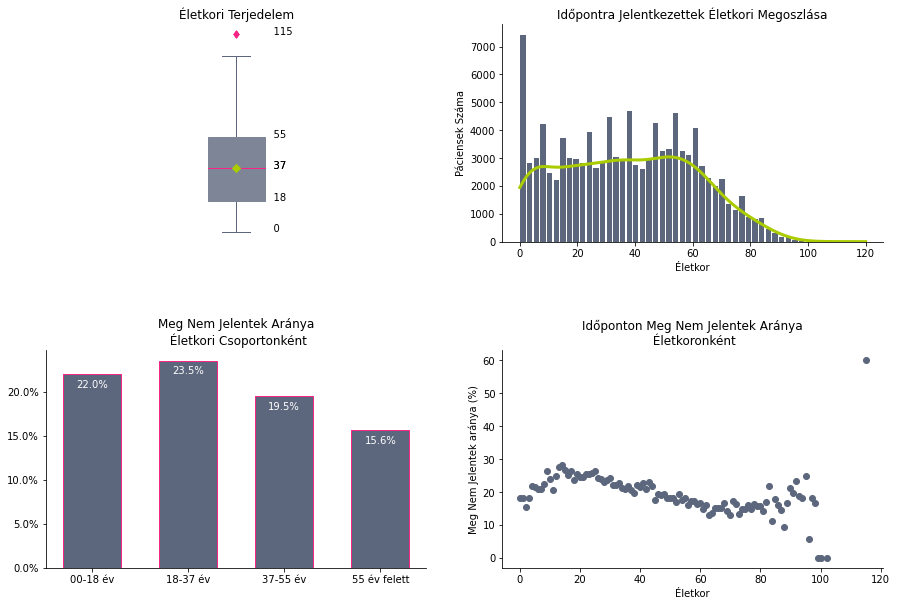

In [35]:
# Tengelyek létrehozása
fig = plt.figure(figsize=(15, 10))
plt.subplots_adjust(hspace = 0.5)
# ax1 = plt.subplot(221)
# ax2 = plt.subplot(222)
# ax3 = plt.subplot(223)
ax1 = plt.subplot2grid((2,2), (0,0))
ax2 = plt.subplot2grid((2,2), (0,1), rowspan=1)
ax3 = plt.subplot2grid((2,2), (1,0), colspan=1)
ax4 = plt.subplot2grid((2,2), (1,1), colspan=1)


# Ax1 BoxPlot
flierprops = dict(marker="d", markerfacecolor=accent0, markeredgecolor='none')

meanpointprops = dict(marker='D', markeredgecolor=accent1,
                      markerfacecolor=accent1)

bp = ax1.boxplot(no_show['Age'], flierprops=flierprops, meanprops=meanpointprops, showmeans=True, patch_artist=True)


for element in ['whiskers', 'fliers', 'caps']:
        plt.setp(bp[element], color=base1)
for element in ['medians']:
        plt.setp(bp[element], color=accent0)
for element in ['boxes']:
        plt.setp(bp[element], color=base0)
        
        
ax1.set_title('Életkori Terjedelem')
ax1.set_ylabel('')
ax1.set_xlabel('')
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.get_xaxis().set_ticks([])
ax1.get_yaxis().set_ticks([])

a = np.array(list(no_show.Age.describe()))
b = [1,3,4,5,6,7]
text_list = list(a[b])

for t in text_list:
    ax1.text(x= 1, y=t, s=" "*12 + str(int(t)))

    
    
# Ax2 - HISZTOGRAM
# Hisztogram létrehozása az életkori megoszlás alapján.
ax2.hist(x=no_show['Age'], 
         bins=50, 
         rwidth=0.8, 
         color=base1, 
         histtype='bar')

# Sűrűségfüggvény létrehozása a hisztogramhoz.
from scipy.stats import gaussian_kde
density = gaussian_kde(no_show['Age'])
xs = np.linspace(0,120,200)
density.covariance_factor = lambda : 0.25
density._compute_covariance()
ax2.plot(xs,density(xs)*no_show.shape[0]*2, color=accent1, linewidth=3 )

# Hisztogram formázása
ax2.set_title('Időpontra Jelentkezettek Életkori Megoszlása')
ax2.set_ylabel('Páciensek Száma')
ax2.set_xlabel('Életkor')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)



# Ax3 - OSZLOPDIAGRAM
# Életkor szerinti kvartilis értékek kiszámítása, és kvartilis cimkék rögzítése új oszlopban
# no_show['Age_Quantile'] = pd.qcut(no_show['Age'], 4)

# Oszlopdiagram paraméterértékeinek rögzítése
megjelentek_aranya = np.array(no_show.groupby('Age_Quantile')['dummy_No-show'].mean())
width = 0.6
labels = ['00-18 év', '18-37 év', '37-55 év', '55 év felett']
heights = (1 - megjelentek_aranya) * 100
title = 'Meg Nem Jelentek Aránya\n Életkori Csoportonként'

custom_bar(ax3, labels, heights, width, title, text_position=-1.5)


        
# Ax4 PONTDIAGRAM
# Időponton meg nem jelentek aránya, életkoronként
prop_show_by_age = prob_show_crosstab(no_show, 'Age')
ax4.scatter(prop_show_by_age['Age'], (1 - prop_show_by_age['prob_megjelenes']) * 100, color=base1);

ax4.set_title('Időponton Meg Nem Jelentek Aránya\n Életkoronként')
ax4.set_ylabel('Meg Nem Jelentek aránya (%)')
ax4.set_xlabel('Életkor')
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)

**Leíró statisztikák:** (Bal felső ábra)<br>
* Az átlag (és a medián) életkor 37 év, és a páciensek 50%-a 15 és 55 év közé esik.
* A legfiatalabb páciens 1 év alatti (0 éves), a legidősebb 115 éves.


**Páciensek életkori megoszlása** (Jobb felső ábra)**:**
* Látható, hogy a leggyakrabban az újszülöttek járnak orvoshoz, az eloszláson itt egy jelentős kiugrás figyelhető meg.
* Az ábráról továbbá leolvasható, az előjegyzések száma az életkorral gyengén ugyan, de pozitívan korrelál. Növekvő tendencia figyelhető meg körülbelül 60 éves korig, ami után a görbe lecseng.
* A megfigyelések **megegyeznek a korrelációs mátrixon látottakkal.**
<blockquote>
    <i>
    Ahhoz, hogy ebből további következtetéseket vonhassunk le, (például, hogy az életkor előrehaladtával nőnek az egészségügyi problémák), szükség lenne az alapnépesség szerkezeti összetételének ismeretére, hiszen lehet, hogy a magasabb életkori csoportba tartozók magasabb számát az okozza, hogy az alapnépességben is nagyobb arányban vannak jelen.
    </i>
</blockquote>

**Időponton meg nem jelentek aránya, életkori csoportonként** (Két alsó ábra)**:**
* Az ábrákról leolvasható, hogy a megjelenés arányában **jelentős különbség** figyelhető meg a különböző **korcsoportok között**.
 * A 18-37 év közöttiek esetében a legmagasabb az arány. Ők az esetek 23,5%-ban nem jelentek meg az előre egyeztetett időpontokban.
 * Ennél 7.8% ponttal alacsonyabb az arány az 55 év felettiek esetében, akik mindössze 15,6%-ban nem jelentek meg.
 * Megfigyelhető továbbá, hogy az összefüggés nem lineáris. Több irányváltás is található benne.
 * Az alsó ábráról továbbá leolvasható, hogy az alacsony mintaszám miatt 80 év fölött megnő a megjelenés valószínűségének szórása (Homoszkedaszticitás).
 * **A korrelációs mátrixon az itt megfigyelhető jelentős különbségek ellenére nagyon gyenge kapcsolatot láthattunk**

<br>

**Kezelésre szoruló problémák:**
 * Heteroszkedaszticitás
   * a 80 év fölötti páciensek egy kategóriába sorolása <br> (pl 80 év fölött mindenki 80 évesnek számít, így nincs szükség dummyzásra)
 * Nem linearitás kezelése
   * négyzetes transzformációval
   * kategórikus osztályközökbe sorolás majd dummy változók kialakítása

<a id='betegseg'></a>
## Krónikus betegségek hatása a megjelenésre
<a href="#tartalomjegyzek">Vissza a tartalomjegyzékhez</a>

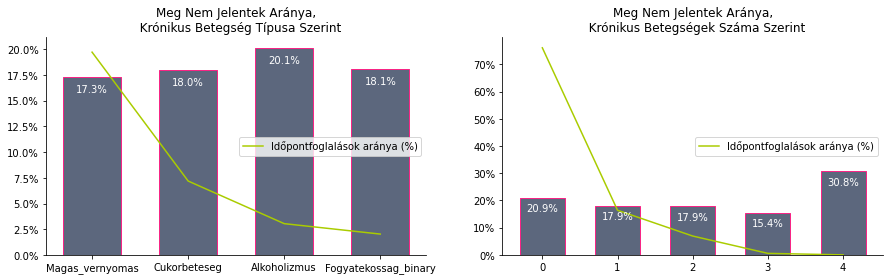

In [7]:
# Tengelyek létrehozása
fig = plt.figure(figsize=(15,10))
plt.subplots_adjust(hspace = 0.5)
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)

# Ax1
# Ax1.Bar 
cols = ['Magas_vernyomas', 'Cukorbeteseg', 'Alkoholizmus', 'Fogyatekossag_binary']
res = prop_show_labels(no_show, cols)

width = 0.6
labels = res['labels']
heights = (1 - res['heights']) * 100
title = 'Meg Nem Jelentek Aránya,\n  Krónikus Betegség Típusa Szerint'

custom_bar(ax1,
           labels,
           heights,
           width,
           title,
           text_position=-1.5)

# Ax1.Line
disease_sum = no_show[cols].sum()
line_heights = disease_sum.values/no_show.shape[0]*100

ax1.plot(labels, line_heights, label='Időpontfoglalások aránya (%)', color=accent1)
ax1.legend(loc=5)




# Ax2
# Ax2.Bar
cols = ['0','1','2','3','4']
res = prop_show_labels(no_show, cols)

width = 0.6
labels = res['labels']
heights = (1 - res['heights']) * 100
title = 'Meg Nem Jelentek Aránya,\n  Krónikus Betegségek Száma Szerint'

custom_bar(ax2,
           labels,
           heights,
           width,
           title,
           text_position=-5)

# Ax2.Line
count_betegsegek_szama = no_show.groupby('betegsegek_szama').count().PatientId
line_heigths =  np.array(count_betegsegek_szama.values/no_show.shape[0]) * 100

ax2.plot(labels,
         line_heigths,
         label='Időpontfoglalások aránya (%)',
         color=accent1)

ax2.legend(loc=5)

plt.show();

#### Krónikus betegségek szerinti megoszlások:
**Bal oldali ábra:**
* Látható, hogy messze a leggyakoribb betegség, a magas vérnyomás, a másik 3 kategória gyakorisága messze elmaradt tőle. (sárga vonal).
* A krónikus beteg pácienseknél a legmagasabb meg NEM jelenési érték az alkoholizmus esetében figyelhető meg <br>(20,1%, ami körülbelül megegyezik a teljes mintában megfigyelt 20,2%-os átlaggal)
* A többi krónikus betegség esetében a meg nem jelenés aránya elmarad az átlagos 20,2%-os értéktől.

**Jobb oldali ábra**
* Látható továbbá, hogy minél több krónikus betegségtől szenved egy páciens, annál nagyobb eséllyel jelenik meg az időpontokon (Jobb oldali ábra, oszlopok)
* Ez alól kivételt képeznek azok a páciensek akik mind a 4 krónikus betegséggel rendelkeznek, de a minta mérete miatt ez az érték figyelmen kívül hagyható ( Jobb oldali ábra, sárga vonal).

**Konklúzió:**
<br>
* A korrelációs mátrixban láthattuk, hogy nincs, vagy minimális kapcsolat van az itt vizsgált változók között. 
  * Egyrészt aztért mert a krónikus betegségek, csak a páciensek kis részét érintik
  * Másrészt jelentősen nem tér el a meg nem jelenés aránya az átlagos 20,2%-tól egyik kategória esetében sem.
* Nem figyeltünk meg olyan anomáliát aminek orvoslásával növelhető lenne a kapcsolat erőssége.


<a id='korabbi'></a>

## Korábbi vizsgálati alkalmak, és korábbi meg nem jelenések hatása
<a href="#tartalomjegyzek">Vissza a tartalomjegyzékhez</a>

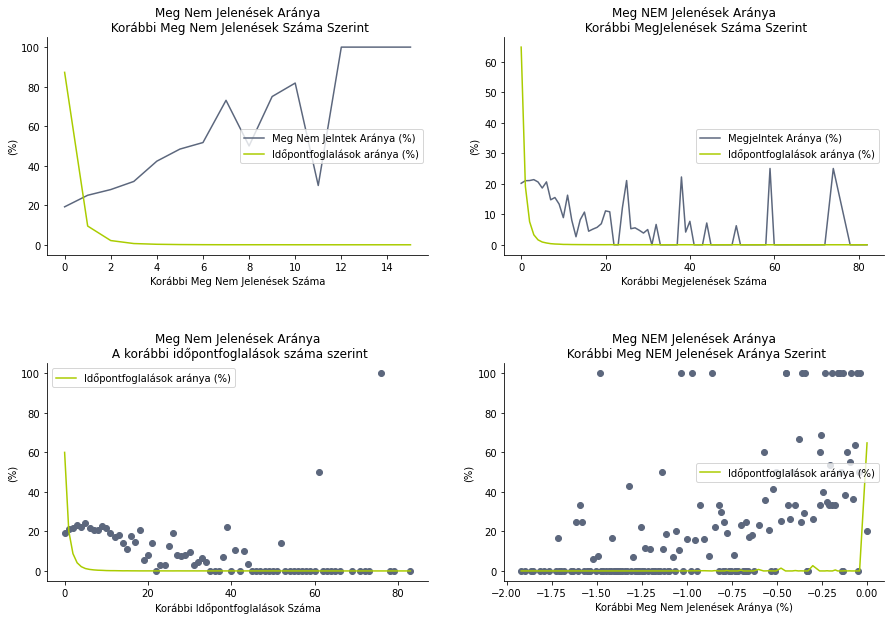

In [46]:
# Tengelyek létrehozása
fig = plt.figure(figsize=(15,10))
plt.subplots_adjust(hspace = 0.5)
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224)


# AX1
# Ax1.Line 1
prop_no_show_by_num_of_noshows = prob_show_crosstab(no_show, 'number_of_no_shows')
ax1.plot(prop_no_show_by_num_of_noshows['number_of_no_shows'],
        (1 - prop_no_show_by_num_of_noshows['prob_megjelenes']) * 100, 
         color=base1,
         label='Meg Nem Jelntek Aránya (%)')

# Ax1.Line 2
labels = np.sort(no_show['number_of_no_shows'].unique())
heights_foglalasok = np.array(no_show.groupby('number_of_no_shows').count().PatientId / no_show.shape[0])*100

ax1.plot(labels, heights_foglalasok , 
         label='Időpontfoglalások aránya (%)', color=accent1)


# Ax1.Format
ax1.set_title('Meg Nem Jelenések Aránya\n Korábbi Meg Nem Jelenések Száma Szerint')
ax1.set_ylabel('(%)')
ax1.set_xlabel('Korábbi Meg Nem Jelenések Száma')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.legend(loc=5)



# AX2
# Ax2.Line 1
prop_show_by_num_of_noshows = prob_show_crosstab(no_show, 'number_of_shows')
ax2.plot(prop_show_by_num_of_noshows['number_of_shows'],
        (1 - prop_show_by_num_of_noshows['prob_megjelenes']) * 100, 
         color=base1,
         label='Megjelntek Aránya (%)')

# Ax2.Line 2
labels = np.sort(no_show['number_of_shows'].unique())
heights_foglalasok = np.array(no_show.groupby('number_of_shows').count().PatientId / no_show.shape[0])*100

ax2.plot(labels, heights_foglalasok , 
         label='Időpontfoglalások aránya (%)', color=accent1)


# Ax2.Format
ax2.set_title('Meg NEM Jelenések Aránya\n Korábbi MegJelenések Száma Szerint')
ax2.set_ylabel('(%)')
ax2.set_xlabel('Korábbi Megjelenések Száma')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.legend(loc=5)



# AX3
# Ax3.Scatter
prop_show_by_number_of_visits = prob_show_crosstab(no_show, 'number_of_visits')
ax3.scatter(prop_show_by_number_of_visits['number_of_visits'],
            (1 - prop_show_by_number_of_visits['prob_megjelenes']) * 100, color=base1);
# ax3.set_xlim(0,20)

# Ax3.Line
labels = np.sort(prop_show_by_number_of_visits['number_of_visits'].unique())
heights = np.array(no_show.groupby('number_of_visits').count().PatientId / no_show.shape[0])*100
ax3.plot(labels, heights , label='Időpontfoglalások aránya (%)', color=accent1)

# Ax3.Format
ax3.set_title('Meg Nem Jelenések Aránya\n A korábbi időpontfoglalások száma szerint')
ax3.set_ylabel('(%)')
ax3.set_xlabel('Korábbi Időpontfoglalások Száma')
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.legend(loc=2)



# AX4
# Ax4.Line 1
prop_show_by_num_of_noshows = prob_show_crosstab(no_show, 'prop_no_show')

ax4.scatter(prop_show_by_num_of_noshows['prop_no_show'],
            (1 - prop_show_by_num_of_noshows['prob_megjelenes']) * 100, color=base1)


# Ax4.Line 2
labels = np.sort(no_show['prop_no_show'].unique())
heights_foglalasok = np.array(no_show.groupby('prop_no_show').count().PatientId / no_show.shape[0])*100

ax4.plot(labels, heights_foglalasok , 
         label='Időpontfoglalások aránya (%)', color=accent1)


# Ax4.Format
ax4.set_title('Meg NEM Jelenések Aránya\n Korábbi Meg NEM Jelenések Aránya Szerint')
ax4.set_ylabel('(%)')
ax4.set_xlabel('Korábbi Meg Nem Jelenések Aránya (%)')
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)
ax4.legend(loc=5)
plt.show();

**Bal felső ábra:** 
* Látható, hogy a két változó között pozitív korreláció áll fenn. Akik korábban már nem jelentek meg, nagyobb valószínűséggel fognak a jövőben sem megjelenni.
* A mgas értékeknél a mintaméret miatt megnövekedett variancia figyelhető meg.

**Jobb felső ábra:** 
* Ezzel szemben akik korábban rendszeresen megjelentek, nagyobb eséllyel fognak most is megjelenni. 
* Az értékek növekedésével csökkenő mintaméret miatt, itt is megnő a variancia az x változó magasabb tartományában.

**Jobb also ábra:** 
* A korábbi időpontfoglalások száma esetében eleinte növekvés, majd csökkenés figyelhető meg. Ez magyarázható azzal, hogy aki több alkalommal foglalt időpontot, annak több alkalommal van lehetősége nem megjelenni.

**Bal alsó ábra:**
* Nincs megfigyelhető tendencia

**Konklúzió:** 
* A modellezés előtt a mintaméret csökkenésével párhuzamos variancianövekedést kezelni kell:
 * kritikus érték fölötti minták csoportosítása
* Korábbi előjegyzések száma, és a korábbi megjelenések számába szerinti arány esetében irányváltás figyelhető meg.
 * négyzetes transzformációval próbáljuk orvosolni (parabola)


<a id='idopont'></a>

## Vizsgálat időpontjának hatása a megjelenésre
<a href="#tartalomjegyzek">Vissza a tartalomjegyzékhez</a>

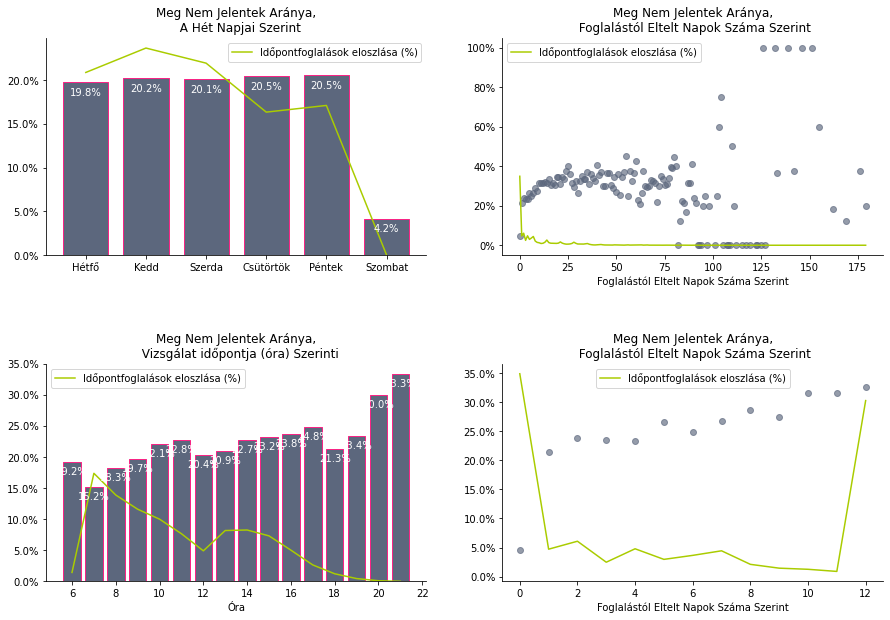

In [230]:
#### Tengelyek létrehozása
fig = plt.figure(figsize=(15,10))
plt.subplots_adjust(hspace = 0.5)
ax1 = plt.subplot2grid((2,2), (0,0))
ax2 = plt.subplot2grid((2,2), (0,1))
ax3 = plt.subplot2grid((2,2), (1,0), colspan=2)



# AX1
# Ax1.Bar
prop_show_by_dayofweek = prob_show_crosstab(no_show, 'DayofWeek')

width = 0.75
labels = ['Hétfő', 'Kedd', 'Szerda', 'Csütörtök', 'Péntek', 'Szombat']
heights = (1- prop_show_by_dayofweek['prob_megjelenes']) * 100
title = 'Meg Nem Jelentek Aránya,\n  A Hét Napjai Szerint'

custom_bar(ax1, labels, heights, width, title, text_position=-1.5, text_color='white')

# Ax3.Line
heights = np.array(no_show.groupby('DayofWeek').count().PatientId / no_show.shape[0])*100
ax1.plot(labels, heights , label='Időpontfoglalások eloszlása (%)', color=accent1)
ax1.legend()




# AX2
# Ax2.Scatter
prop_show_by_age = prob_show_crosstab(no_show, 'Num_days_to_appointment')
x = prop_show_by_age['Num_days_to_appointment']
y = (1 - prop_show_by_age['prob_megjelenes']) * 100

ax2.scatter(x, y, color=base1, alpha=0.65);

ax2.set_title('Meg Nem Jelentek Aránya,\n Foglalástól Eltelt Napok Száma Szerint')
ax2.set_xlabel('Foglalástól Eltelt Napok Száma Szerint')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
# ax2.spines['left'].set_alpha(0.1)
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())

# Ax2.Line
heights = np.array(no_show.groupby('Num_days_to_appointment').count().PatientId / no_show.shape[0])*100

ax2.plot(x, heights , label='Időpontfoglalások eloszlása (%)', color=accent1)
ax2.legend()

# --------------------------------------------------------------------------------------
# Opcionálisan megjeleníthető plot:
# AX4
# Ax4.Scatter
ax3 = plt.subplot2grid((2,2), (1,0), colspan=1)
ax4 = plt.subplot2grid((2,2), (1,1), colspan=1)
prop_show_by_age = prob_show_crosstab(no_show, 'Num_days_to_appointment_capped')
x = prop_show_by_age['Num_days_to_appointment_capped']
y = (1 - prop_show_by_age['prob_megjelenes']) * 100


ax4.scatter(x, y, color=base1, alpha=0.65);

ax4.set_title('Meg Nem Jelentek Aránya,\n Foglalástól Eltelt Napok Száma Szerint')
ax4.set_xlabel('Foglalástól Eltelt Napok Száma Szerint')
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)
# ax2.spines['left'].set_alpha(0.1)
ax4.yaxis.set_major_formatter(mtick.PercentFormatter())

heights = np.array(no_show.groupby('Num_days_to_appointment_capped').count().PatientId / no_show.shape[0])*100

ax4.plot(x, heights , label='Időpontfoglalások eloszlása (%)', color=accent1)
ax4.legend()

# --------------------------------------------------------------------------------------

# AX3
# Ax3.Bar
prop_show_by_scheduledhour = prob_show_crosstab(no_show, 'ScheduledHour')

width = 0.8
labels = np.sort(prop_show_by_scheduledhour['ScheduledHour'].unique())
heights = (1- prop_show_by_scheduledhour['prob_megjelenes']) *100
title = 'Meg Nem Jelentek Aránya,\n  Vizsgálat időpontja (óra) Szerinti'
ax3.set_xlabel('Óra')

custom_bar(ax3, labels, heights, width, title, text_position=-2, text_color='white', show_text='pct')

# Ax3.Line
heights = np.array(no_show.groupby('ScheduledHour').count().PatientId / no_show.shape[0])*100
ax3.plot(labels, heights , label='Időpontfoglalások eloszlása (%)', color=accent1)
ax3.legend()
plt.show();

**Bal felső ábra:** 
* A hét napjainak gyakorlatilag nincs hatása a meg nem jelenésekre.
* Kivétel a szombat, ott viszont olyan kicsi a minta, hogy ezért nincs gyakorlati jelentősége.
 * Esetleg statisztikai próbával vizsgálhatjuk, hogy szignifikáns e a mért 4,2%-os érték.

**Jobb felső ábra:** 
* Az x változó első szegmensében (0-25 nap között) jól megfigyelhető tendenica olvasható le az ábráról. 
 * Minél több nap telik el az előjegyzés regisztrációja, és a vizsgálati időpont között, annál nagyobb a valószínűsége, hogy a páciens nem jelenik meg. 
* A mintaméret csökkenésével párhuzamosan itt is nő a szórás, amit modellezés előtt kezelni kell.

**Also ábra:** 
* Megfigyelhető, hogy a munkadiő alatti előjegyzések esetében a meg nem jelenés aránya magas.
* Míg a reggeli, a munkaidő utáni, valamint az ebédidő alatti időpontok esetében alacsonyabb. 
* A késő esti időpontok esetében az érték kiugróan magas, viszont a minta méret (sárga vonal) miatt további vizsgálat szükséges annak megállapítására, hogy a mért értékek szignifikánsak e.

**Konklúzió**: 
* A foglalástól eltelt napok száma esetében kezelni kell a heteroszkedaszticitást.
 * log transzformáció, vagy kritikus érték fölötti minták csoportosítása
* Jelentős különbségek figyelhetők meg a megjelenés arányában a vizsgálat időpontjának függvényében.
 * Az összefüggés nem lineáris. Ennek kezelésére **hozzunk létre dummy változót minden órához.**
 * Továbbá az **alacsony mintaméretű időpontok esetében hipotézis teszttel** vizsgáljuk, hogy a mért értkek szignifikánsak e.

<a id='varosresz'></a>
## Városrész hatásának vizsgálata
<a href="#tartalomjegyzek">Vissza a tartalomjegyzékhez</a>

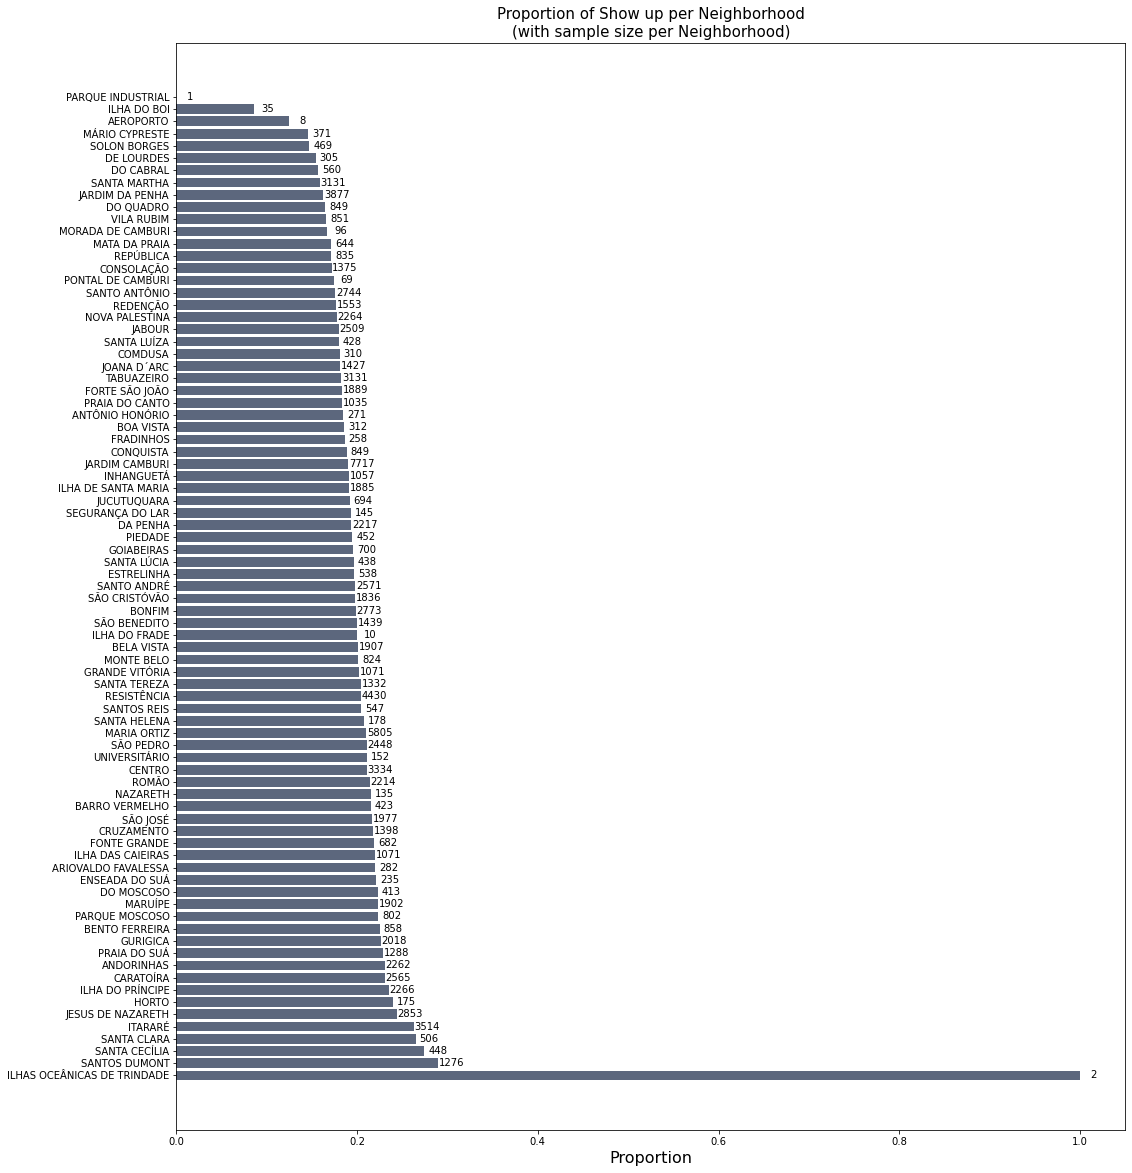

In [10]:
#Calculating the proportion of the show-ups for all Neighborhood
df_sum = no_show.groupby('Neighborhood').sum()['dummy_No-show']
df_count = no_show.groupby('Neighborhood').count()['dummy_No-show']
prop_no_show =  1-(df_sum / df_count)

# Creating a df from the count and the proportion values
df_prop = pd.DataFrame(prop_no_show).merge(pd.DataFrame(df_count), on='Neighborhood')

#Renaming the columns and sorting the table by the show-up proportion
df_prop.rename(columns={'dummy_No-show_x' : 'prop_show', 'dummy_No-show_y' : 'number_of_appointments'}, inplace= True)
df_prop.sort_values(by='prop_show', ascending=False, inplace=True)

#Initializing our figure object and plotting a horizontal bar chart
plt.figure(figsize=(17,20))
plt.barh(y=df_prop.index, width=df_prop.prop_show, color=base1);

#iterating through on the bar chart indexes and annotating the sample size on each bar.
for i, w, c in zip(df_prop.index, df_prop.prop_show, df_prop.number_of_appointments):
    plt.text(w + 0.015, i, c, va='center', ha='center', color='black')
    
#Formatting our chart
plt.title('Proportion of Show up per Neighborhood\n(with sample size per Neighborhood)', fontsize=15)
plt.xlabel('Proportion', fontsize=16);

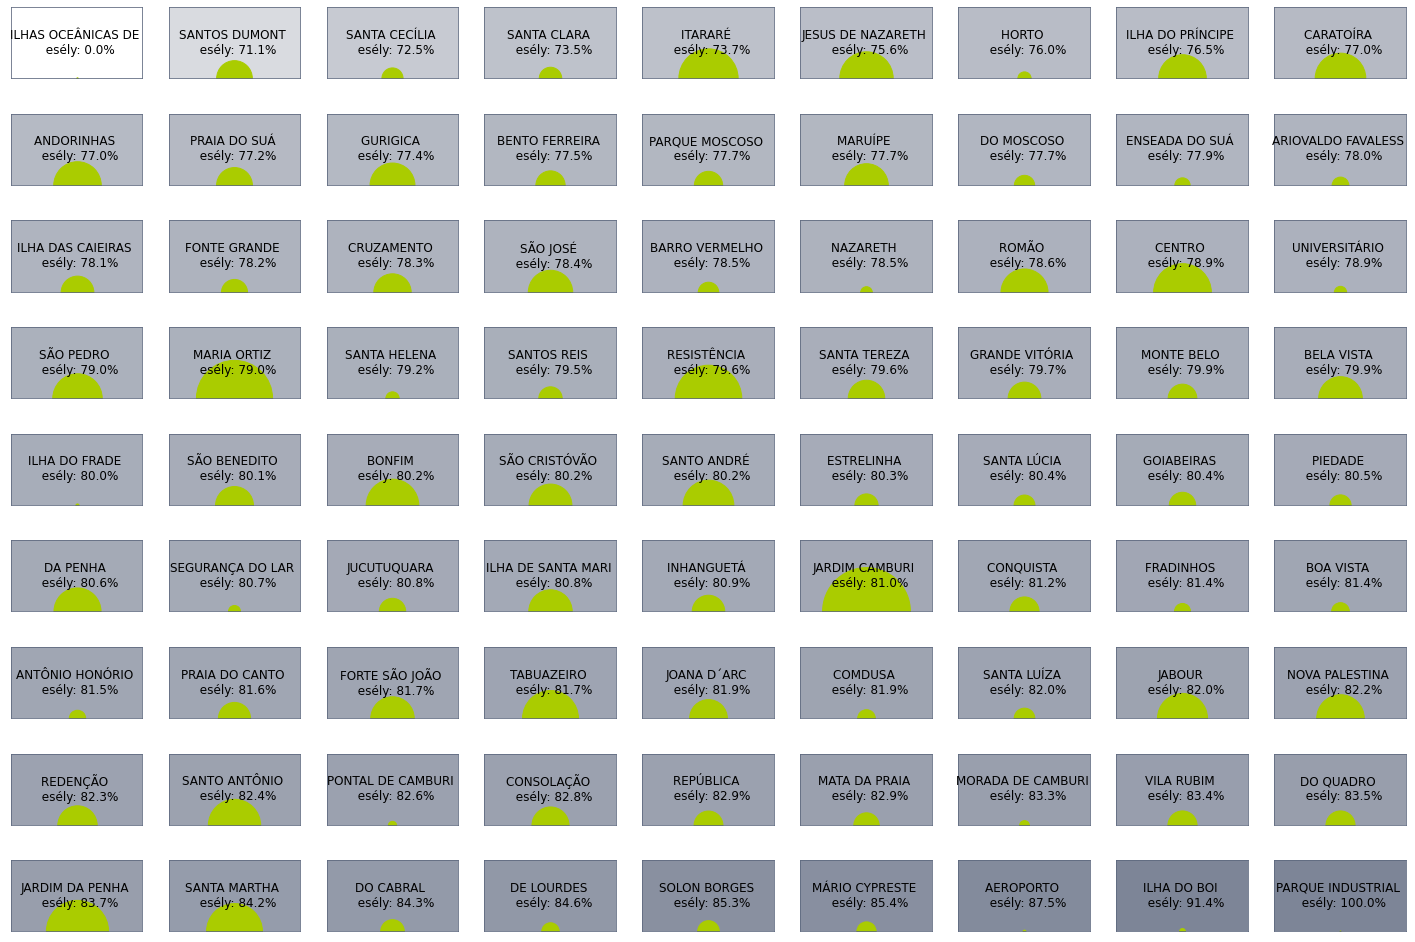

In [11]:
# Prepare data
# prop_no_show =  1-prop_no_show

prop_no_show =  df_sum / df_count
df_prop.sort_values(by='prop_show', inplace=True)

prop = df_prop.sort_values(by='prop_show', ascending=False).prop_show
prop = np.round(100-prop*100,1) 
visits = df_prop.sort_values(by='prop_show', ascending=False).number_of_appointments
text =  df_prop.sort_values(by='prop_show', ascending=False).index

vals = prop_no_show.sort_values(ascending=False).values

mini = vals[79]
maxi = vals.max()
vals = (vals - mini) / (maxi-mini)
vals

# Creating Visualization

fig = plt.figure(figsize=(25,17))

for r in range(81):
    col_index = int(np.trunc(r/9))
    row_index = np.mod(r,9)
        
    plt.subplots_adjust(hspace = 0.5)
    ax = plt.subplot2grid((9,9), (col_index, row_index))
    rgba = cmap(vals[r])
    ax.set_facecolor(rgba)
    ax.scatter(0.5,0.5, visits[r], c=accent1)
    
    if vals[r] < 0.1:
        text_color = 'w'
    else:
        text_color = 'black'
    
    ax.text(0.5,
            visits.max() / 2,
            f'{text[r][:18]} \n  esély: {prop[r]}%', 
            ha='center',
            va='center',
            color='black',
            size=12)
    
    ax.set_ylim([0, visits.max()])
    ax.spines['left'].set_color(base1)
    ax.spines['right'].set_color(base1)
    ax.spines['top'].set_color(base1)
    ax.spines['bottom'].set_color(base1)
    ax.axes.yaxis.set_visible(False)
    ax.axes.xaxis.set_visible(False)


#### Konklúzió:
* Látható, hogy **jelentős különbségek vannak az egyes városrészek esetében** a megjelenési arányban (esély % a téglalapokon, illetve a téglalap színárnyalata)
* Viszont nagyon nagy a mintaméretek közötti szórás (sárga kör), ezért annak eldöntésére, hogy a számított értékek statisztikailag szignifikánsak e, **további satisztikai próbák elvégzése szükséges.**


<a id='egyeb'></a>

## Egyéb Változók hatásának vizsgálata
<a href="#tartalomjegyzek">Vissza a tartalomjegyzékhez</a>

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  # Remove the CWD from sys.path while we load stuff.


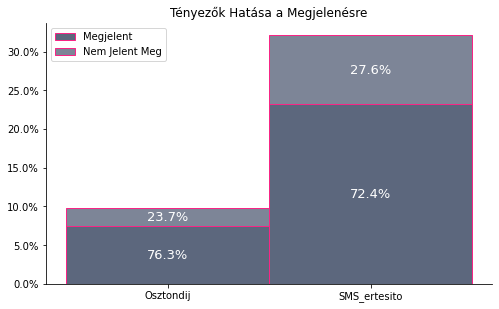

In [12]:
# Tengelyek létrehozása
fig = plt.figure(figsize=(8,12))
plt.subplots_adjust(hspace = 0.5)
ax1 = plt.subplot(211)

# Oszlopdiagram: Páciensek aránya

labels = ['Osztondij', 'SMS_ertesito']
prop_show = prop_show_labels(no_show, labels)['heights']

categories = no_show[labels].sum().values/no_show.shape[0] * 100
categories_bottom = categories * prop_show
categories_top = categories - categories_bottom

width = 1

custom_bar(ax=ax1,
           label=labels,
           height=categories_bottom,
           width=width,
           title='Tényezők Hatása a Megjelenésre',
           edgecolor=accent0,
           bar_color=base1,
           show_text='',
           name='Megjelent')

custom_bar(ax=ax1,
           label=labels,
           height=categories_top,
           width=width,
           title='Tényezők Hatása a Megjelenésre',
           bottom=categories_bottom,
           text_color=accent1,
           edgecolor=accent0,
           bar_color=base0,
           show_text='',
           name='Nem Jelent Meg')

ax1.legend()


# Oszlopdiagram: Meg Nem Jelentek Aránya


ax1.text(labels[0],
         categories_bottom[0] / 2,
         str(np.round(prop_show[0]*100,1)) + '%', 
         ha='center',
         va='center',
         color="white",
         size=13)

ax1.text(labels[1],
         categories_bottom[1] / 2,
         str(np.round(prop_show[1]*100,1)) + '%', 
         ha='center', 
         va='center',
         color="white",
         size=13)


ax1.text(labels[0],
         categories_bottom[0] + categories_top[0] / 2,
         str(np.round((1-prop_show[0])*100,1)) + '%', 
         ha='center',
         va='center', 
         color="white",
         size=13)

ax1.text(labels[1],
         categories_bottom[1] + categories_top[1] / 2,
         str(np.round((1-prop_show[1])*100,1)) + '%', 
         ha='center', 
         va='center',
         color="white",
         size=13)

plt.show();

* Az állami ösztöndíjban programban résztvevő páciensek aránya 10% a teljes mintában.
 * Az ide tartozó páciensek esetében a meg nem jelenés aránya némileg magasabb (23.7%) az átlagos értéknél (20.2%), de nem jelentősen.
 * A mintaméret és a kis eltérés miatt nincs nagy magyarázó hatása a változónak, ami egybecseng a korrelációs mátrixnál látottakkal.
* Azon páciensek, akik SMS emlékeztetőt kaptak az előjegyzésük időpontjáról, több mint 30%-át teszik ki a teljes mintának.
 * Az ő esetükben a meg nem jelenők aránya lényegesen magasabb (27,6%) az átlagos értéktől (20.2%), ami a várakozásokkal ellentétes.
 * Nem ismertek az SMS-ek kiküldésének részletei (mi alapján, mennyivel az előjegyzés előtt, hány sms-t küldted stb), így nem tudjuk megmagyarázni, hogy miért kaptunk ilyen értéket. **További informácókra van szükség a változóval kapcsolatban.**

<a id='konkluzio'></a>
## Összefoglalás
<a href="#tartalomjegyzek">Vissza a tartalomjegyzékhez</a>

### Magyarázóerő:
* Összességében azt láttuk, hogy minden magyarázó változónk nagyon gyenge kapcsolatot mutat a célváltozóval.


* A legerősebb kapcsolat a következő változók esetében volt megfigyelhető:
     * **Regisztrációtól eltelt napok száma** (Num_days_to_appointment): -0.19
     * **SMS értesítő**: -0.13
     * **Korábbi meg nem jelenések száma** (number_of_no_shows): -0.08
     
     <br>

### Kezelendő problémák:
* Néhány további változó esetében olyan anomáliákat és összefüggéseket figyeltünk meg, amik kezelésével a modell magyarázó ereje tovább növelhető:
<br>

* **Nem linearitások kezelése:**
   * A **ScheduledHour (vizsgálat időpontja)** változó esetében több irányváltást, illetve klasztert figyelhettünk meg (munkaidő előtt-után, munkaidő alatt, ebédidő, későesti órák), ami lineárisan nagyon nehezen modellezhető.
     * Készítsünk dummy változót a nap minden órájához.
   * **number_of_shows (megjelenések száma)** valamint a **number_of_visits (korábbi előjegyzések száma)** változók esetében irányváltás figyelhető meg. 
     * Parabolikus, négyzetes transzformációval próbáljuk kezelni.


 * **Heteroszkedaszticitás kezelése:**
   * Több magyarázó változó esetében figyelhető meg, hogy a változó értékének növekedésével csökken az adott értékhez tartozó elemszám.
   * Ezekben a tartományokban a kis minta méret miatt a véletlen hatása felnagyítódik, tendenciák nem figyelhetők meg.
   * Ennek kezelésére a változó azon értékeit, amik az értintett tartományba tartoznak, rendezzük egy csoportba.
     * **például:** ha 80 év felett jelentkezik ez a jelenség, akkor az összes 80 év feletti páciens életkorát írjuk át 80 évre. <br> Ehhez használjunk egy új változót, hogy az eredeti értékek is rendelkezésre álljanak.
   * Érintett változók:
     * Age (életkor)
     * Betegségek száma
     * Korábbi meg nem jelenések száma (number_of_no_shows)
     * Korábbi megjelenések száma (number_of_shows)
     * Korábbi előjegyzések száma (number_of_visits)
     * Eltelt napok száma a regisztrációtól (Num_days_to_appointment)


### Statisztikai próbák:
* Az alábbi változók esetében, **további statisztikai próbákra (hipotézis teszt) van szükség**, annak megállapítására, hogy a kapott eredmények statisztikailag szignifikánsak e, vagy csak a véletlennek köszönhetőek.
<br>

 * Erre azoknál a változóknál van szükség, ahol:
   * Sok kategóriára bontjuk az adatainkat. 
   * A magyarázó változó egyes kategóriákhoz tartozó átlagos értékei között jelentős különbség van.
   * Bizonyos kategóriák mintamérete alacsony.
   * Érintett változók:
      * Neighbourhood (városrész)
      * ScheduledHour (vizsgálat időpontja)


### Az elemzést korlátozó tényezők:
* Alapvető információk az időpontfoglalásokkal kapcsolatban nem állnak rendelkezésre:
 * Vizsgálat típusa (rendszeres, első vizsgálat, kontroll)
 * Az osztály, ahová az időpontfoglalás szól (Szemészet, egy napos sebészet, bőrgyógyászat, tüdőgondozó stb)
 * Az egészségügyi probléma súlyossága


* SMS emlékeztetők kiküldésének módja, időpontja, oka és egyéb részletei nem tisztázottak, ezért a változó elemzésekor kapott értékek értelmezése nem lehetséges.


* Fogyatékosság változó esetén nem tisztázott, hogy a különbözé (0-4) értékek pontoan mit jelentenek (halmozott fogyatékosság, vagy a fogyatékosság típusa)


* Kizárólag a magyarázóváltozók célváltozóval való összefüggését vizsgáltuk, további vizsgálat végezhető a magyarázóváltozók közötti kapcsolatok feltárására. (Például melyik városrészekben jellemző alkoholizmus, vagy melyik életkori csoportban a legjelentősebb a cukorbetegség), de a megoldandó üzleti probléma szempontjából ezek nem érdekesek.